In [182]:
!pip install geopandas

   ---------------------------------------- 0.0/16.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.2 MB ? eta -:--:--
    --------------------------------------- 0.3/16.2 MB ? eta -:--:--
    --------------------------------------- 0.3/16.2 MB ? eta -:--:--
   - -------------------------------------- 0.5/16.2 MB 699.0 kB/s eta 0:00:23
   - -------------------------------------- 0.8/16.2 MB 781.4 kB/s eta 0:00:20
   - -------------------------------------- 0.8/16.2 MB 781.4 kB/s eta 0:00:20
   -- ------------------------------------- 1.0/16.2 MB 799.2 kB/s eta 0:00:19
   --- ------------------------------------ 1.3/16.2 MB 818.6 kB/s eta 0:00:19
   --- ------------------------------------ 1.3/16.2 MB 818.6 kB/s eta 0:00:19
   --- ------------------------------------ 1.6/16.2 MB 822.8 kB/s eta 0:00:18
   ---- ----------------------------------- 1.8/16.2 MB 825.2 kB/s eta 0:00:18
   ---- ----------------------------------- 1.8/16.2 MB 825.2 kB/s eta 0:00:18
   ----- 

# Load & Prepare Dataset

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import warnings
import geopandas as gpd
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('./data/Fraud_Data.csv')

In [3]:
data.shape

(151112, 11)

In [4]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [5]:
print(data.columns)

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class'],
      dtype='object')


In [6]:
data['signup_time'] = pd.to_datetime(data['signup_time'])
data['purchase_time'] = pd.to_datetime(data['purchase_time'])

In [7]:
data = data.drop(columns=['user_id', 'device_id'])

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   signup_time     151112 non-null  datetime64[ns]
 1   purchase_time   151112 non-null  datetime64[ns]
 2   purchase_value  151112 non-null  int64         
 3   source          151112 non-null  object        
 4   browser         151112 non-null  object        
 5   sex             151112 non-null  object        
 6   age             151112 non-null  int64         
 7   ip_address      151112 non-null  float64       
 8   class           151112 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(3), object(3)
memory usage: 10.4+ MB


# Feature Engineering

In [9]:
# Extract meaningful features
data['signup_month'] = data['signup_time'].dt.month
data['signup_day'] = data['signup_time'].dt.day
data['signup_hour'] = data['signup_time'].dt.hour
data['signup_weekday'] = data['signup_time'].dt.weekday  # 0 = Monday, 6 = Sunday

In [10]:
# Sine and Cosine Transformations for cyclical 'signup_hour'
data['signup_hour_sin'] = np.sin(2 * np.pi * data['signup_hour'] / 24)
data['signup_hour_cos'] = np.cos(2 * np.pi * data['signup_hour'] / 24)

In [11]:
# Do the same for purchase_time
data['purchase_month'] = data['purchase_time'].dt.month
data['purchase_day'] = data['purchase_time'].dt.day
data['purchase_hour'] = data['purchase_time'].dt.hour
data['purchase_weekday'] = data['purchase_time'].dt.weekday  # 0 = Monday, 6 = Sunday

In [12]:
# Sine and Cosine Transformations for cyclical 'purchase_hour'
data['purchase_hour_sin'] = np.sin(2 * np.pi * data['purchase_hour'] / 24)
data['purchase_hour_cos'] = np.cos(2 * np.pi * data['purchase_hour'] / 24)

In [13]:
# Calculate time difference in seconds
data['time_diff'] = (data['purchase_time'] - data['signup_time']).dt.total_seconds()

In [14]:
data = data.drop(columns=['signup_time', 'purchase_time'])

# IP Addresses

In [15]:
ip_map = pd.read_csv('./data/IpAddress_to_Country.csv')  

In [16]:
ip_map.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [17]:
ip_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [18]:
def map_country(ip):
    row = ip_map[(ip_map['lower_bound_ip_address'] <= ip) & (ip_map['upper_bound_ip_address'] >= ip)]
    if not row.empty:
        return row['country'].values[0]
    return 'Unknown'

In [19]:
warnings.filterwarnings('ignore')

In [20]:
data['country'] = data['ip_address'].apply(map_country)

In [21]:
data['country'].value_counts()

country
United States     58049
Unknown           21966
China             12038
Japan              7306
United Kingdom     4490
                  ...  
Myanmar               1
Vanuatu               1
Dominica              1
Niger                 1
Guadeloupe            1
Name: count, Length: 182, dtype: int64

# EDA (Part 1)

In [22]:
# EDA: Summary statistics and missing values
print("Missing values:\n", data.isnull().sum())

Missing values:
 purchase_value       0
source               0
browser              0
sex                  0
age                  0
ip_address           0
class                0
signup_month         0
signup_day           0
signup_hour          0
signup_weekday       0
signup_hour_sin      0
signup_hour_cos      0
purchase_month       0
purchase_day         0
purchase_hour        0
purchase_weekday     0
purchase_hour_sin    0
purchase_hour_cos    0
time_diff            0
country              0
dtype: int64


In [23]:
data.describe()

,purchase_value,age,ip_address,class,signup_month,signup_day,signup_hour,signup_weekday,signup_hour_sin,signup_hour_cos,purchase_month,purchase_day,purchase_hour,purchase_weekday,purchase_hour_sin,purchase_hour_cos,time_diff
count,151112.000000,151112.000000,1.511120e+05,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,1.511120e+05,1.511120e+05
mean,36.935372,33.140704,2.152145e+09,0.093646,4.147593,14.731060,11.490404,3.027265,-0.002345,-1.276336e-03,6.008629,15.278495,11.521593,3.011819,-0.001898,-2.665805e-03,4.932029e+06
std,18.322762,8.617733,1.248497e+09,0.291336,2.256968,8.730886,6.916248,2.006972,0.707585,7.066279e-01,2.660637,8.814117,6.912474,2.006203,0.706923,7.072876e-01,3.126263e+06
min,9.000000,18.000000,5.209350e+04,0.000000,1.000000,1.000000,0.000000,0.000000,-1.000000,-1.000000e+00,1.000000,1.000000,0.000000,0.000000,-1.000000,-1.000000e+00,1.000000e+00
25%,22.000000,27.000000,1.085934e+09,0.000000,2.000000,7.000000,5.000000,1.000000,-0.707107,-7.071068e-01,4.000000,8.000000,6.000000,1.000000,-0.707107,-7.071068e-01,2.186754e+06
50%,35.000000,33.000000,2.154770e+09,0.000000,4.000000,14.000000,12.000000,3.000000,0.000000,-1.836970e-16,6.000000,15.000000,12.000000,3.000000,0.000000,-1.836970e-16,4.926346e+06
75%,49.000000,39.000000,3.243258e+09,0.000000,6.000000,22.000000,17.000000,5.000000,0.707107,7.071068e-01,8.000000,23.000000,17.000000,5.000000,0.707107,7.071068e-01,7.644524e+06
max,154.000000,76.000000,4.294850e+09,1.000000,8.000000,31.000000,23.000000,6.000000,1.000000,1.000000e+00,12.000000,31.000000,23.000000,6.000000,1.000000,1.000000e+00,1.036797e+07


In [24]:
numerical_cols = [
    'purchase_value', 'age', 'time_diff', 'signup_month', 'signup_day', 'signup_weekday',
    'purchase_month', 'purchase_day', 'purchase_weekday'
]

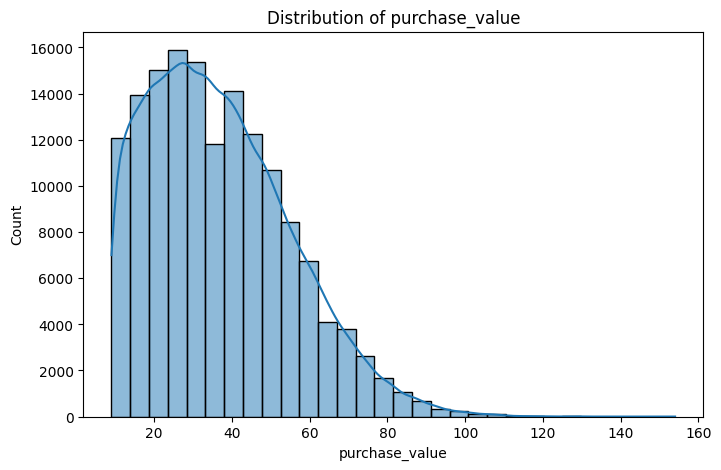

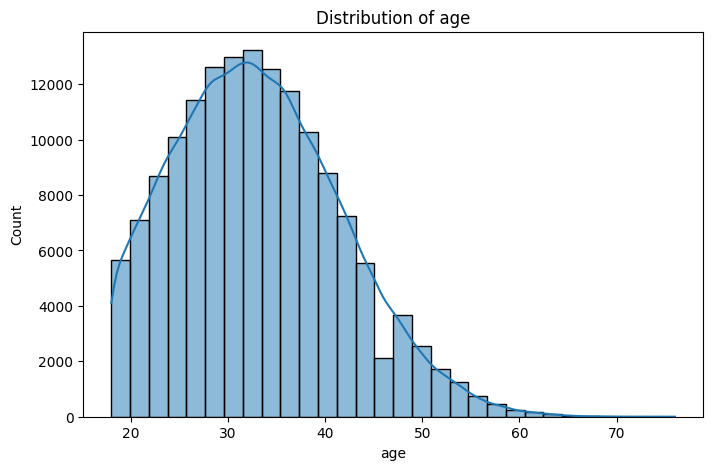

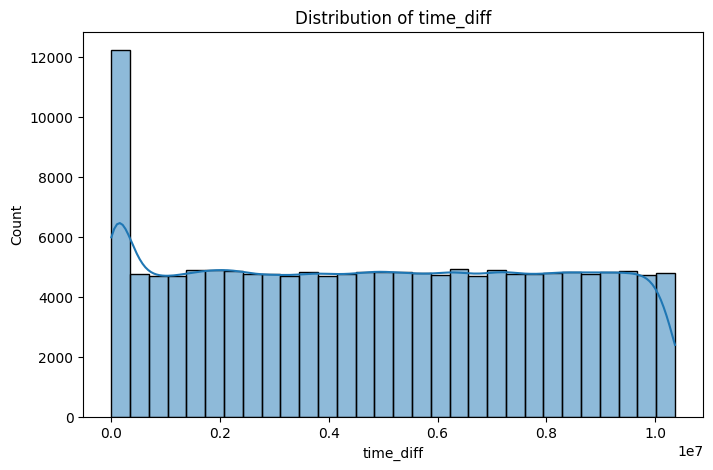

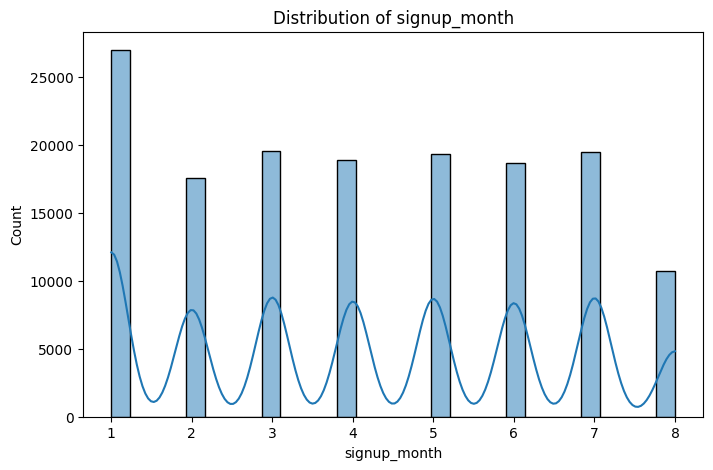

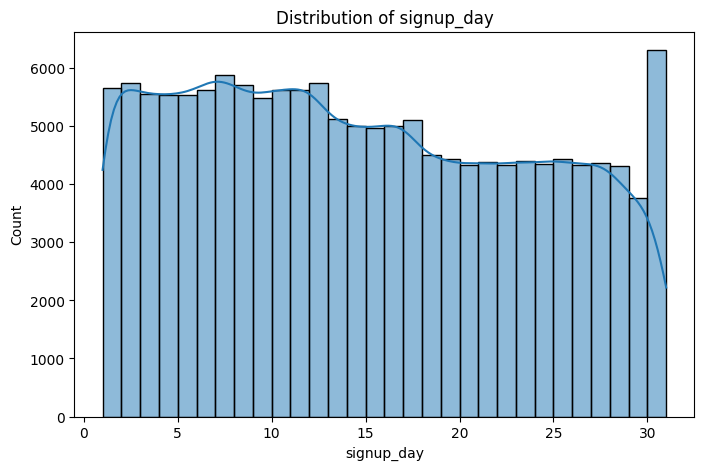

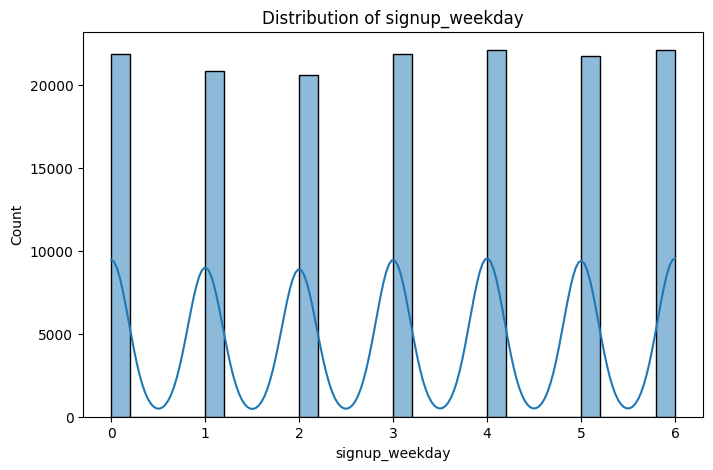

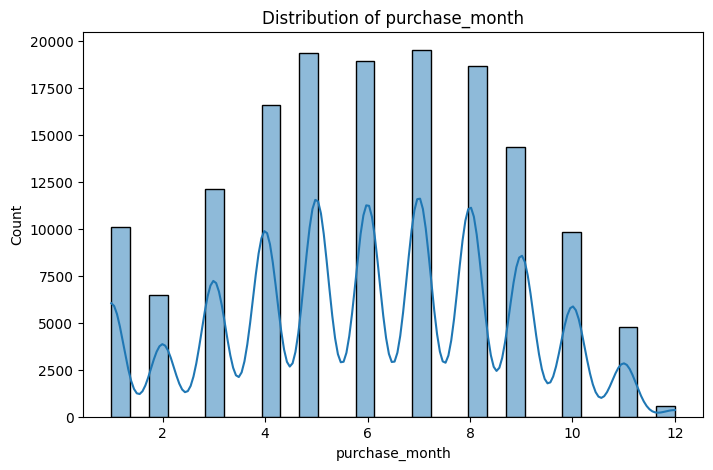

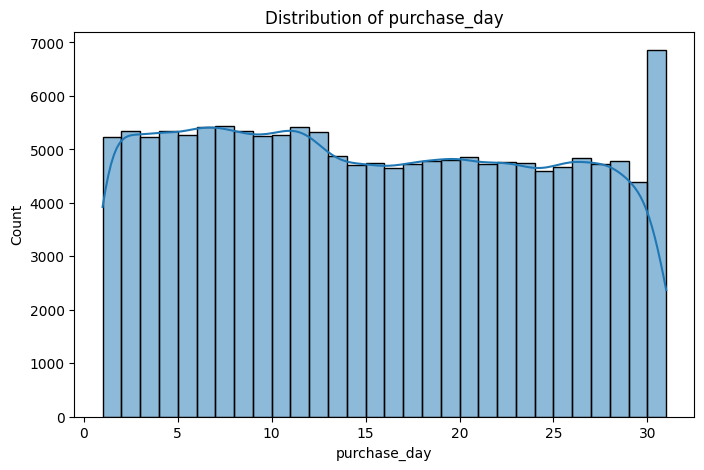

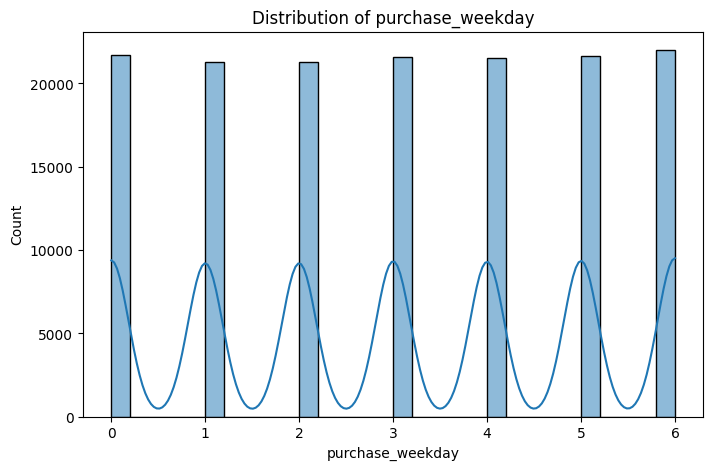

In [25]:
for col in numerical_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

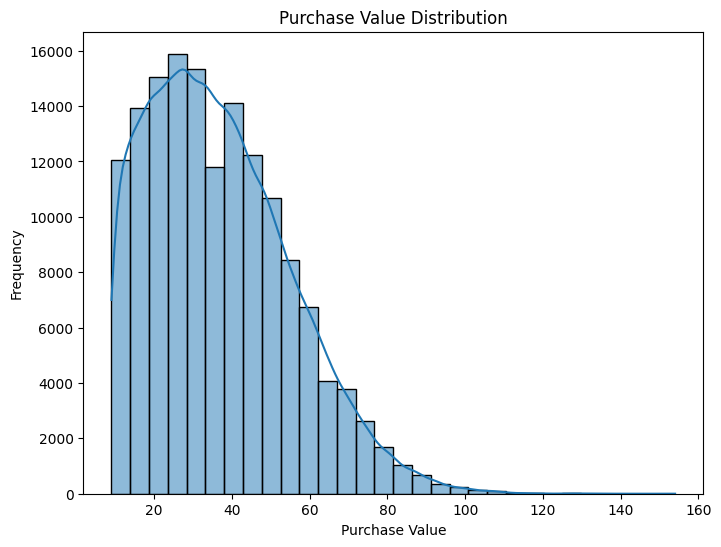

In [26]:
# Visualization 2: Histogram of 'purchase_value'
plt.figure(figsize=(8, 6))
sns.histplot(data['purchase_value'], bins=30, kde=True)
plt.title("Purchase Value Distribution")
plt.xlabel("Purchase Value")
plt.ylabel("Frequency")
plt.show()

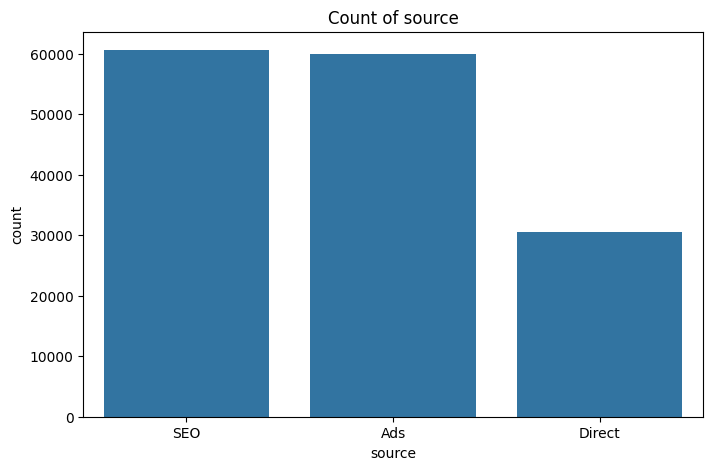

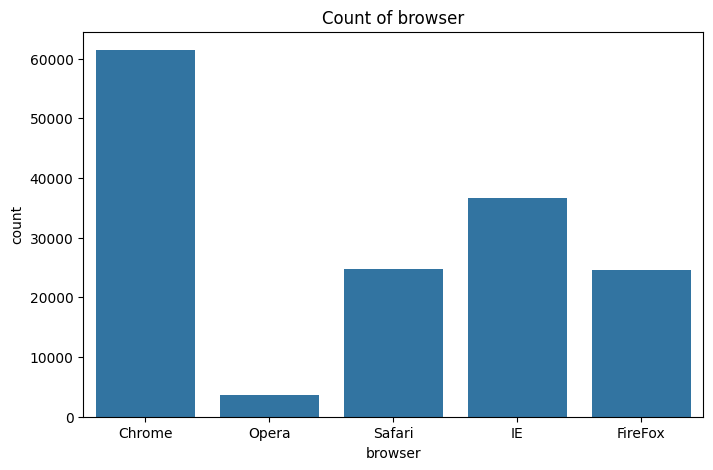

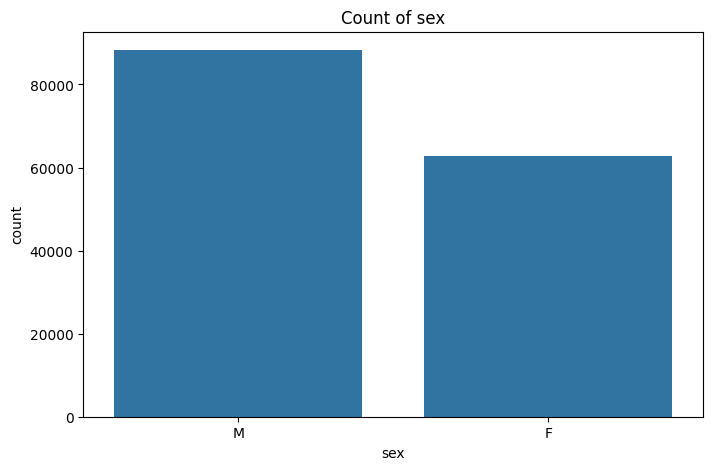

In [27]:
categorical_cols = ['source', 'browser', 'sex']
for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=data[col])
    plt.title(f'Count of {col}')
    plt.show()

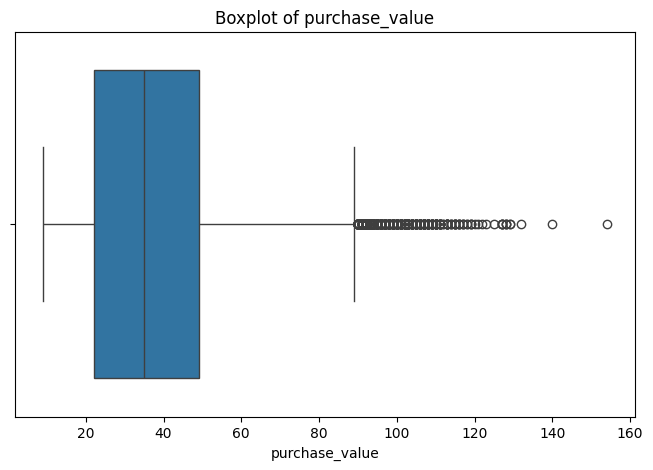

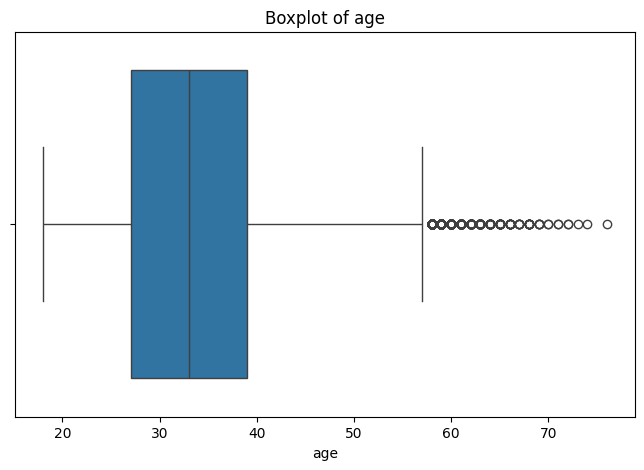

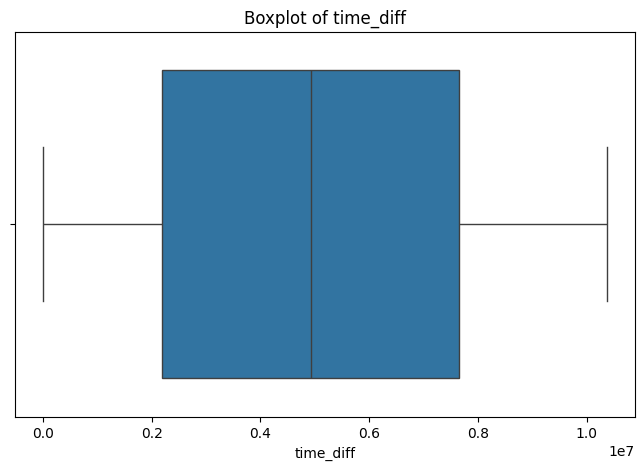

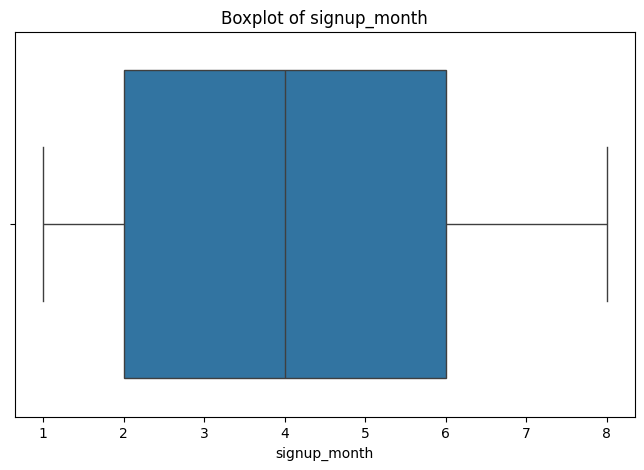

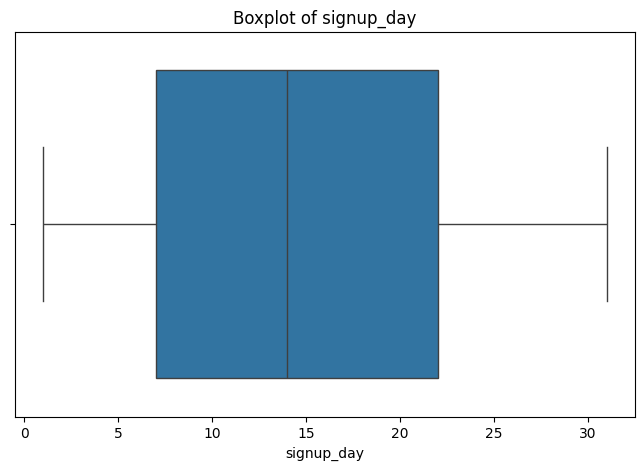

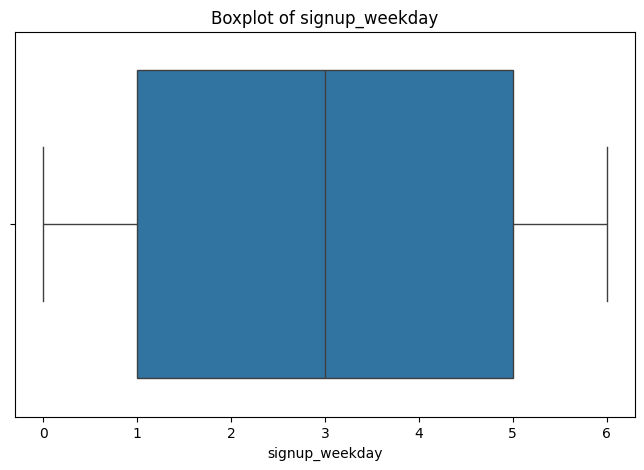

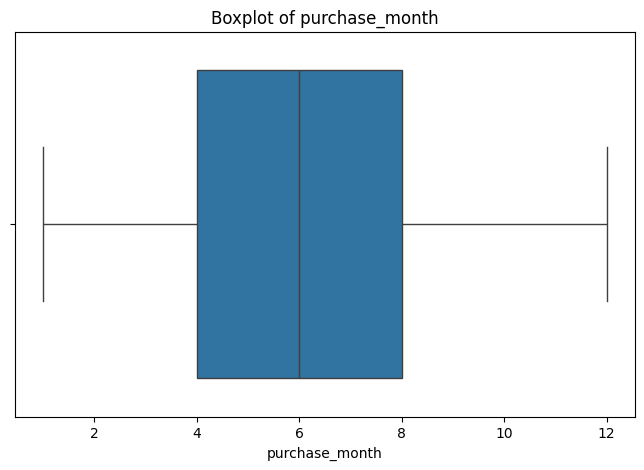

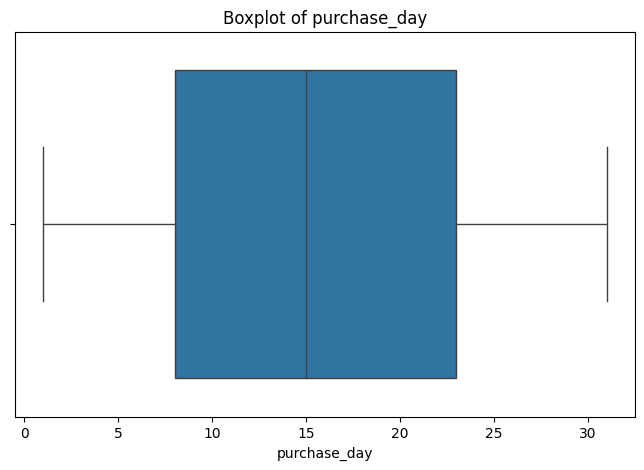

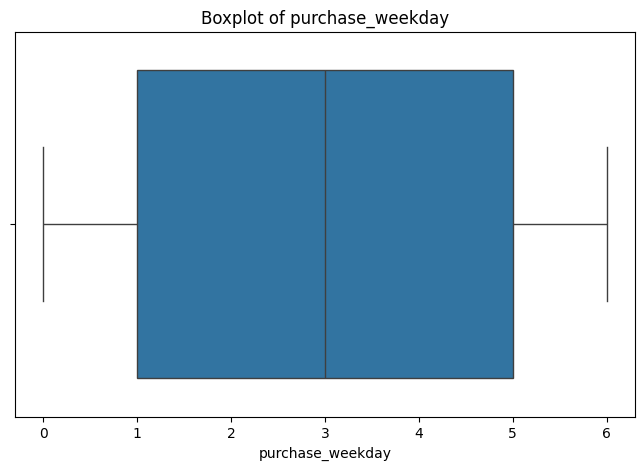

In [28]:
# Boxplots to detect outliers
for col in numerical_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

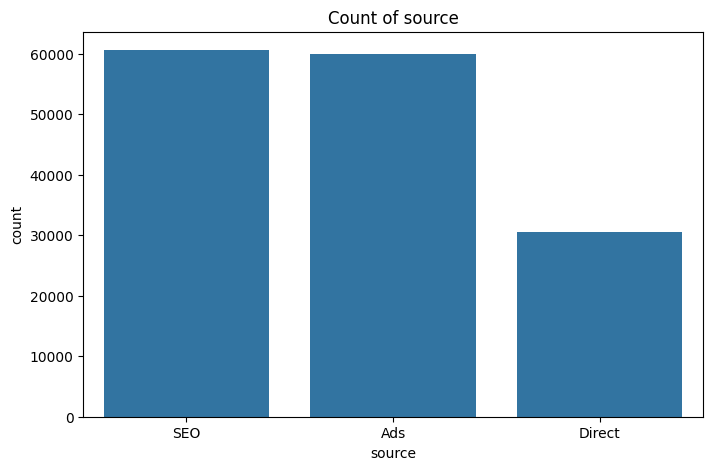

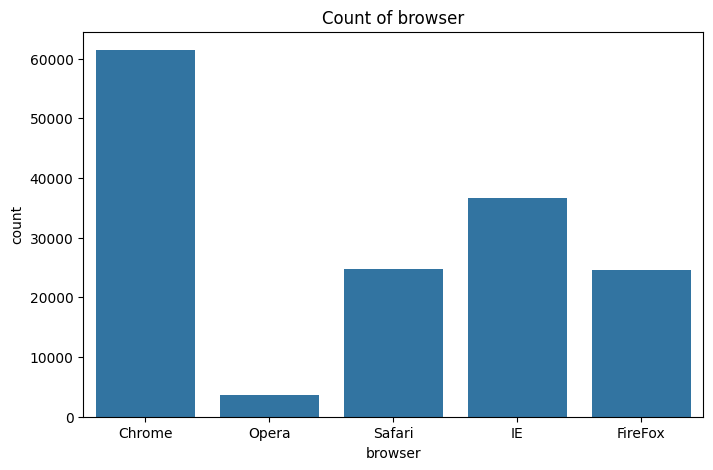

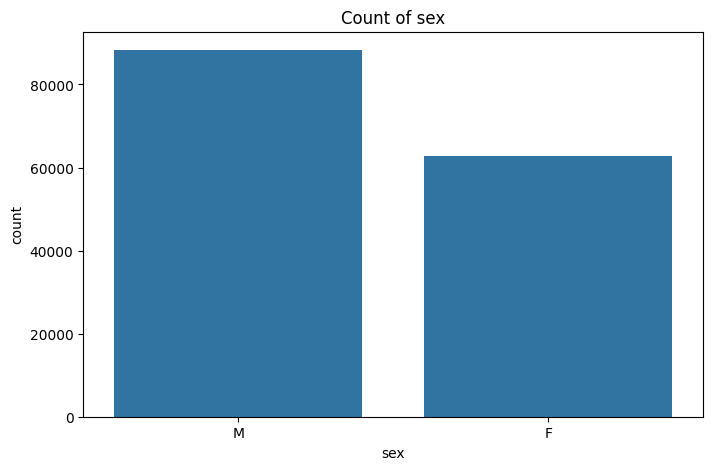

In [29]:
# Bar plots for categorical features
categorical_cols = ['source', 'browser', 'sex']
for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=data[col])
    plt.title(f'Count of {col}')
    plt.show()

In [30]:
# Correlation heatmap for numeric columns
numeric_df = data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()

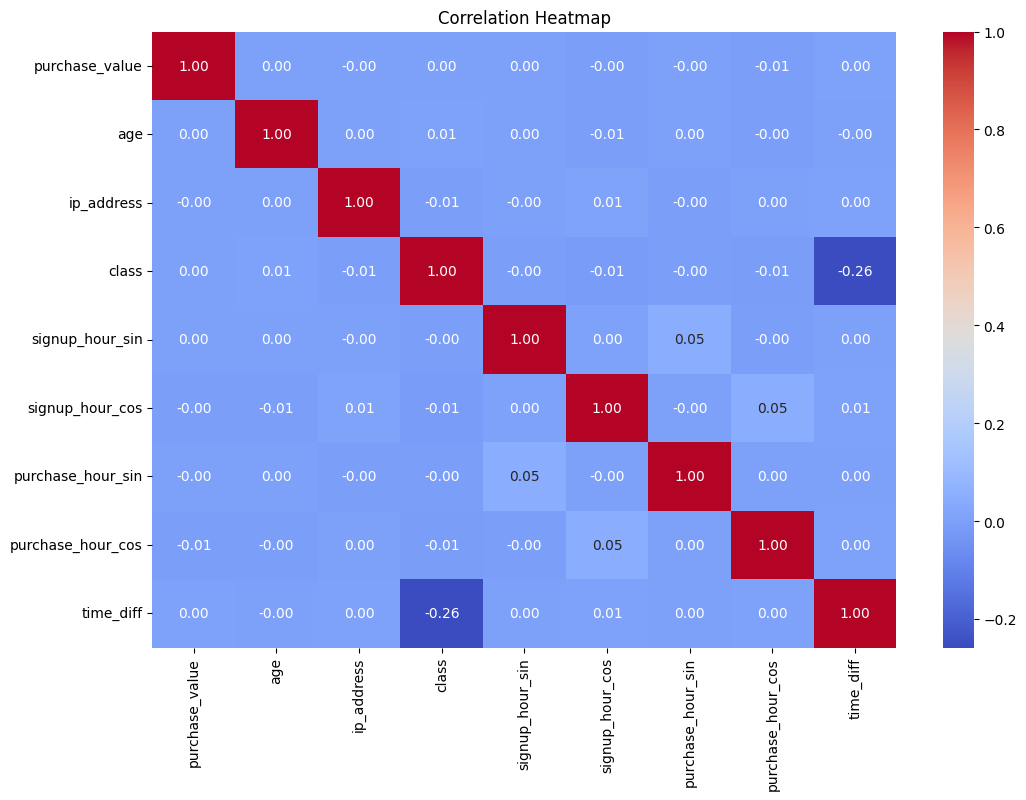

In [31]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

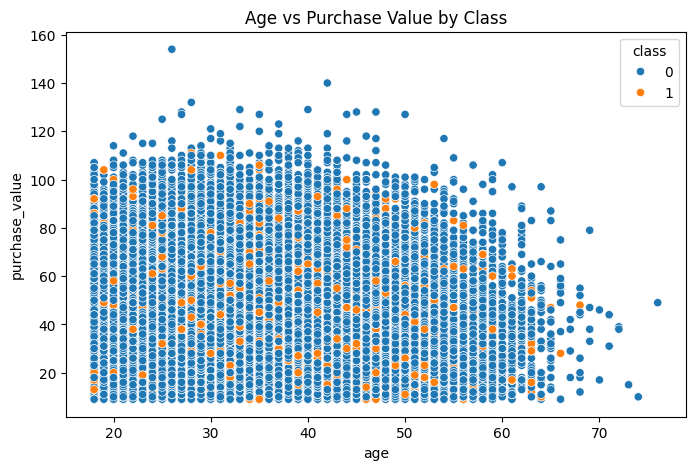

In [32]:
# Scatter plot for relationships between numerical features
plt.figure(figsize=(8, 5))
sns.scatterplot(x='age', y='purchase_value', hue='class', data=data)
plt.title('Age vs Purchase Value by Class')
plt.show()

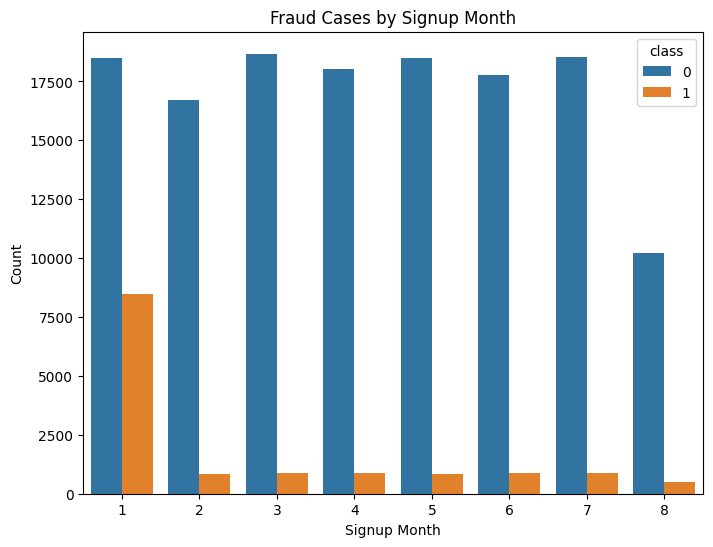

In [33]:
# Visualization 4: Bar plot of fraud cases by 'signup_month'
if 'signup_month' in data.columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=data, x='signup_month', hue='class')
    plt.title("Fraud Cases by Signup Month")
    plt.xlabel("Signup Month")
    plt.ylabel("Count")
    plt.show()

In [34]:
# Frequency distribution of countries (before encoding)
country_frequency = data['country'].value_counts()

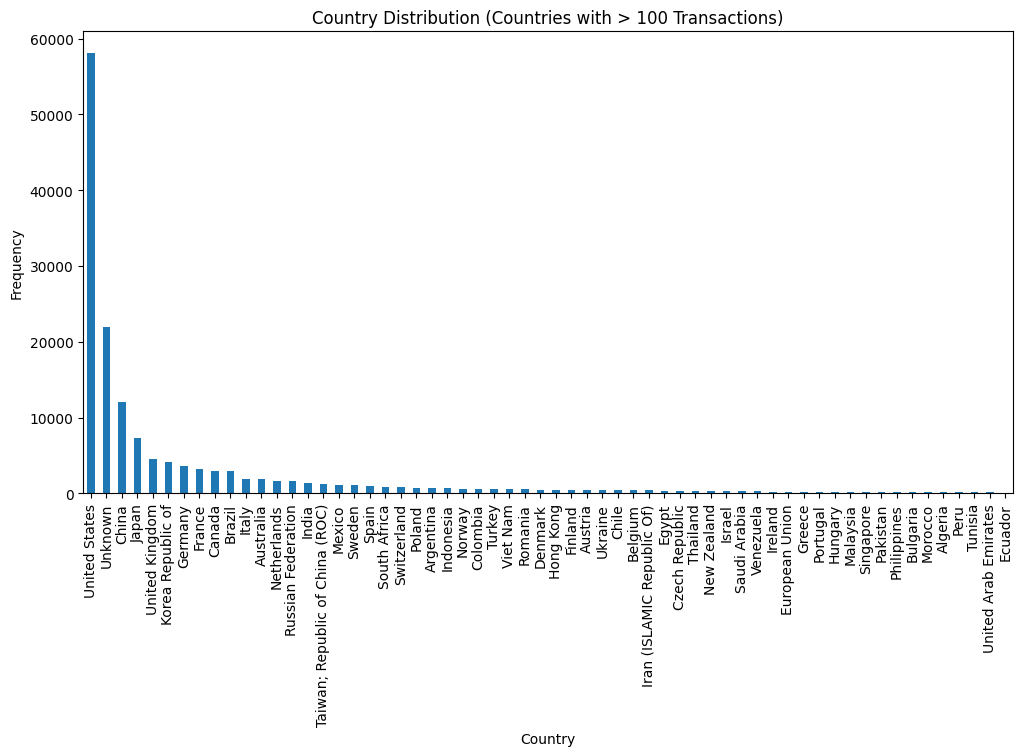

In [35]:
# Define a frequency threshold
threshold = 100

# Filter countries with frequency above the threshold
frequent_countries = country_frequency[country_frequency > threshold]

# Bar plot for country frequencies above the threshold
plt.figure(figsize=(12, 6))
frequent_countries.plot(kind='bar')
plt.title(f'Country Distribution (Countries with > {threshold} Transactions)')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [36]:
fraud_by_country = data[data['class'] == 1]['country'].value_counts()

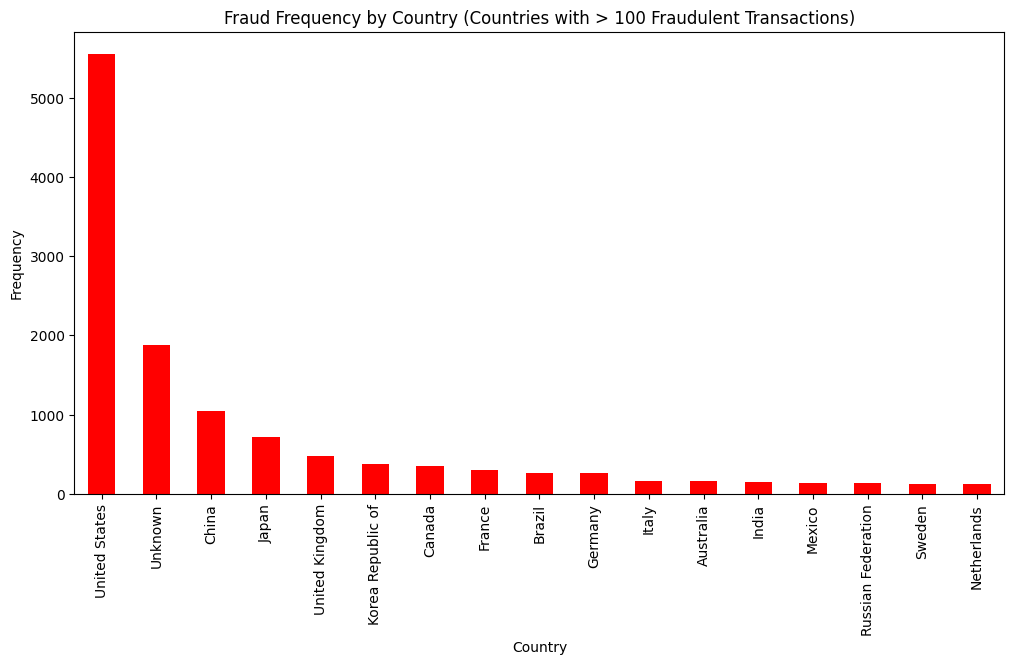

In [37]:
# Fraud frequency by country above the threshold
fraud_by_country_filtered = fraud_by_country[fraud_by_country > threshold]

plt.figure(figsize=(12, 6))
fraud_by_country_filtered.plot(kind='bar', color='red')
plt.title(f'Fraud Frequency by Country (Countries with > {threshold} Fraudulent Transactions)')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [38]:
# Load the world shapefile from the downloaded Natural Earth data
world = gpd.read_file("./data/ne_110m_admin_0_countries.shp")

In [39]:
# Merge country data for fraud visualization
fraud_map_data = fraud_by_country.reset_index()
fraud_map_data.columns = ['country', 'fraud_count']
world = world.merge(fraud_map_data, how='left', left_on='NAME', right_on='country')
world['fraud_count'] = world['fraud_count'].fillna(0)

In [40]:
# Normalize fraud count for color scaling
world['fraud_count_normalized'] = np.log1p(world['fraud_count'])  # Log transformation for large ranges

<Figure size 1500x1000 with 0 Axes>

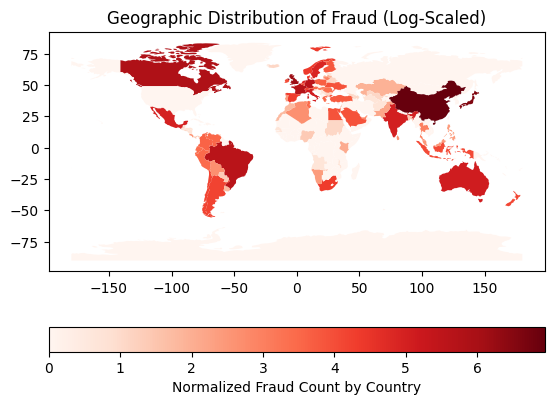

In [41]:
# Plot fraud map
plt.figure(figsize=(15, 10))
world.plot(column='fraud_count_normalized', cmap='Reds', legend=True, 
           legend_kwds={'label': "Normalized Fraud Count by Country", 'orientation': "horizontal"})
plt.title('Geographic Distribution of Fraud (Log-Scaled)')
plt.show()

# Outlier Handling

In [42]:
pre_df = data.copy()

In [43]:
# Handle outliers using Z-score
z_scores = np.abs(stats.zscore(pre_df[numerical_cols]))
pre_df = pre_df[(z_scores < 3).all(axis=1)]  # Retain rows with z-score < 3

# Encoding

In [44]:
pre_df = pd.get_dummies(pre_df, columns=categorical_cols, drop_first=True)

In [45]:
# Convert True/False to 1/0 for all boolean columns
for col in pre_df.columns:
    if pre_df[col].dtype == bool:
        pre_df[col] = pre_df[col].astype(int)

In [46]:
# Frequency encoding for 'country'
country_frequency = pre_df['country'].value_counts()
pre_df['country_encoded'] = pre_df['country'].map(country_frequency)

# Drop the original 'country' column after encoding
pre_df = pre_df.drop(columns=['country'])

To avoid data leakage:

In [47]:
# Train/Test Split (Before Scaling)
X = pre_df.drop(columns=['class'])
y = pre_df['class']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [57]:
X_test['age'].mean() # for later usage

33.07878828362446

In [49]:
scaler = StandardScaler()
X_train[['country_encoded']] = scaler.fit_transform(X_train[['country_encoded']])
X_test[['country_encoded']] = scaler.transform(X_test[['country_encoded']])

In [52]:
numerical_cols += ['signup_hour_sin', 'signup_hour_cos', 'purchase_hour_sin', 'purchase_hour_cos']
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# EDA (Part 2)

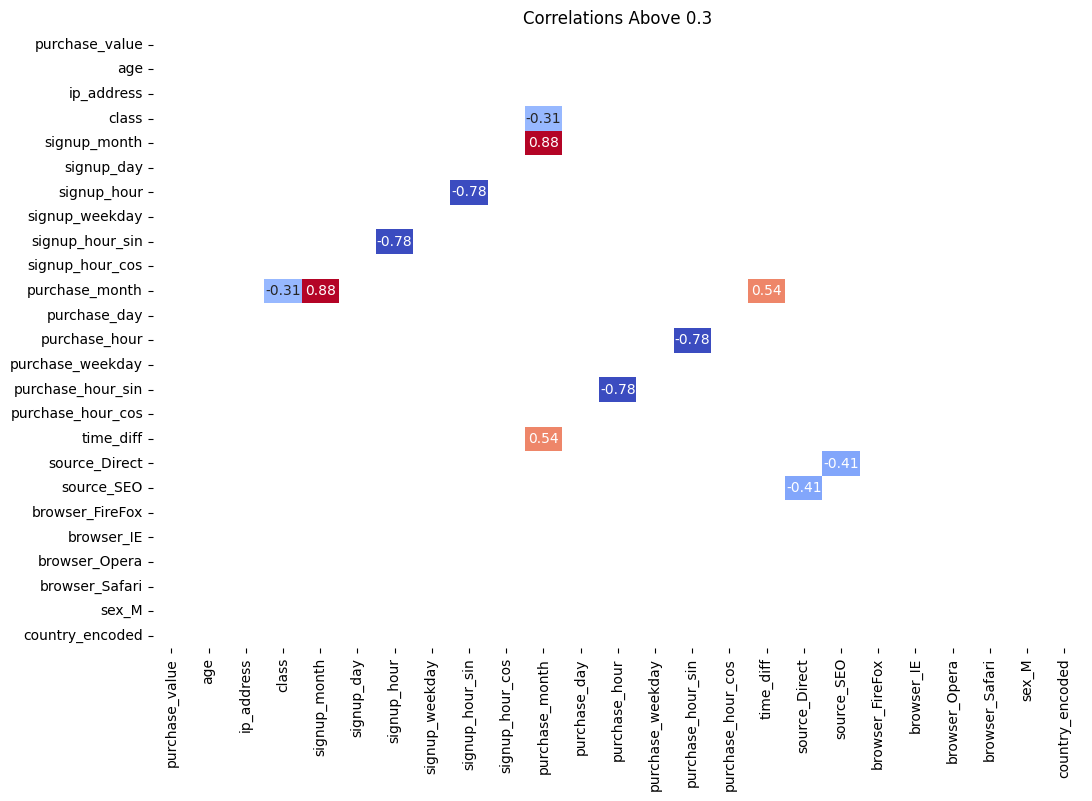

In [53]:
# Compute the correlation matrix
correlation_matrix = pre_df.corr()

# Filter correlations above a threshold
threshold = 0.3
high_correlation = correlation_matrix[(correlation_matrix.abs() > threshold) & (correlation_matrix != 1.0)]

# Display correlations above the threshold
plt.figure(figsize=(12, 8))
sns.heatmap(high_correlation, annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
plt.title(f'Correlations Above {threshold}')
plt.show()

# Save Datasets

In [54]:
# Save scaled datasets
train_scaled = pd.concat([X_train, y_train], axis=1)
test_scaled = pd.concat([X_test, y_test], axis=1)

train_scaled.to_parquet('./data/train_scaled.parquet', index=False)
test_scaled.to_parquet('./data/test_scaled.parquet', index=False)